# Exercise 1: Magnetostatics

In [1]:
include(joinpath(dirname(@__DIR__), "config.jl"))
paths = get_project_paths("examples")

# Ensure the module is reloaded if changed
if isdefined(Main, :MagnetostaticsFEM)
    println("Reloading MagnetostaticsFEM...")
    # A simple way to force reload in interactive sessions
    try; delete!(LOAD_PATH, joinpath(paths["SRC_DIR"], "src")); catch; end
    try; delete!(Base.loaded_modules, Base.PkgId(Base.UUID("f8a2b3c4-d5e6-f7a8-b9c0-d1e2f3a4b5c6"), "MagnetostaticsFEM")); catch; end
end
include(joinpath(paths["SRC_DIR"], "MagnetostaticsFEM.jl"))

using LinearAlgebra
using Plots
using LaTeXStrings
using Gridap
using .MagnetostaticsFEM

┌ Warning: Replacing docs for `Main.MagnetostaticsFEM.WeakFormProblem :: Union{}` in module `Main.MagnetostaticsFEM`
└ @ Base.Docs docs/Docs.jl:243
┌ Warning: Replacing docs for `Main.MagnetostaticsFEM.magnetostatics_1d_weak_form :: Tuple{Gridap.Geometry.Triangulation, Gridap.CellData.Measure, AbstractArray, Any, Any}` in module `Main.MagnetostaticsFEM`
└ @ Base.Docs docs/Docs.jl:243
┌ Warning: Replacing docs for `Main.MagnetostaticsFEM.magnetodynamics_1d_harmonic_weak_form :: Tuple{Gridap.Geometry.Triangulation, Gridap.CellData.Measure, AbstractArray, Any, Any, Any, Float64}` in module `Main.MagnetostaticsFEM`
└ @ Base.Docs docs/Docs.jl:243
┌ Warning: Replacing docs for `Main.MagnetostaticsFEM.magnetodynamics_1d_harmonic_coupled_weak_form :: Tuple{Gridap.Geometry.Triangulation, Gridap.CellData.Measure, AbstractArray, Any, Any, Any, Float64}` in module `Main.MagnetostaticsFEM`
└ @ Base.Docs docs/Docs.jl:243
┌ Warning: Replacing docs for `Main.MagnetostaticsFEM.magnetodynamics_2d_harmon

## Define Parameters and Paths

In [2]:
# Model Parameters
J0 = 2.2e4       # Source current density [A/m²] (Assumed Real)
μ0 = 4e-7 * pi  # Vacuum permeability [H/m]
μr_core = 1500.0 # Relative permeability of the core
σ_core = 1e6    # Conductivity of the core [S/m]
freq = 50    # Frequency [Hz]
ω = 2 * pi * freq # Angular frequency [rad/s]

# FEM Parameters
order = 3
field_type = ComplexF64 # Still use ComplexF64 marker for setup_fe_spaces
dirichlet_tag = "D"
dirichlet_value = 0.0 + 0.0im # Dirichlet BC for A = u + iv

# Paths
mesh_file = joinpath(paths["GEO_DIR"], "coil_geo.msh")
output_file_base = joinpath(paths["OUTPUT_DIR"], "magnetodynamics_harmonic_coupled")

println("Mesh file: ", mesh_file)
println("Output directory: ", paths["OUTPUT_DIR"])

Mesh file: /Users/ezracerpac/PycharmProjects/FutureDistributionSystemsAM/examples/geo/coil_geo.msh
Output directory: /Users/ezracerpac/PycharmProjects/FutureDistributionSystemsAM/examples/output


## Setup FEM Problem

In [3]:
# Load mesh and tags
model, labels, tags = load_mesh_and_tags(mesh_file)

# Get material tags dictionary
material_tags = get_material_tags(labels)

# Set up triangulation and measures
Ω = Triangulation(model)
dΩ = Measure(Ω, 2*order)

# Define material property functions
reluctivity_func = define_reluctivity(material_tags, μ0, μr_core)
conductivity_func = define_conductivity(material_tags, σ_core)
source_current_func = define_current_density(material_tags, J0) # Real source

# Setup FE spaces (multi-field: Real, Imag parts)
U, V = setup_fe_spaces(model, order, field_type, dirichlet_tag, dirichlet_value)

# Define the weak form problem for the coupled system
problem = magnetodynamics_1d_harmonic_coupled_weak_form(Ω, dΩ, tags, reluctivity_func, conductivity_func, source_current_func, ω)

Info    : Reading '/Users/ezracerpac/PycharmProjects/FutureDistributionSystemsAM/examples/geo/coil_geo.msh'...
Info    : 15 entities
Info    : 114 nodes
Info    : 115 elements
Info    : Done reading '/Users/ezracerpac/PycharmProjects/FutureDistributionSystemsAM/examples/geo/coil_geo.msh'
Setting up multi-field spaces (Real, Imag) for Complex problem.


WeakFormProblem(Main.MagnetostaticsFEM.var"#a#32"{Gridap.CellData.GenericMeasure, Float64, Gridap.CellData.OperationCellField{ReferenceDomain}, Gridap.CellData.OperationCellField{ReferenceDomain}}(GenericMeasure(), 314.1592653589793, OperationCellField(), OperationCellField()), Main.MagnetostaticsFEM.var"#b#33"{Gridap.CellData.GenericMeasure, Gridap.CellData.OperationCellField{ReferenceDomain}}(GenericMeasure(), OperationCellField()))

## Solve FEM Problem

In [4]:
# Solve the linear FE system
uv = solve_fem_problem(problem, U, V) # uv is a MultiFieldFEFunction

# Extract real and imaginary parts
u = uv[1] # Real part of Az
v = uv[2] # Imag part of Az

SingleFieldFEFunction():
 num_cells: 113
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 16847727135577330974

## Post-processing

In [5]:
# Compute B-field (Real and Imag parts)
B_re, B_im = calculate_b_field(uv)

# Compute Eddy Currents (Real and Imag parts)
J_eddy_re, J_eddy_im = calculate_eddy_current(uv, conductivity_func, ω, Ω, tags)

# Define helper functions for magnitude squared
mag_sq_scalar(re, im) = re*re + im*im
mag_sq_vector(re, im) = inner(re, re) + inner(im, im)

# Calculate Magnitudes for saving/plotting using composition
Az_mag = sqrt ∘ (mag_sq_scalar ∘ (u, v))
B_mag = sqrt ∘ (mag_sq_vector ∘ (B_re, B_im))
Jeddy_squared = mag_sq_vector ∘ (J_eddy_re, J_eddy_im)
Jeddy_mag = sqrt ∘ Jeddy_squared

# Save results to VTK format
save_results_vtk(Ω, output_file_base, 
    Dict(
        "Az_re" => u, "Az_im" => v, "Az_mag" => Az_mag,
        "B_re" => B_re, "B_im" => B_im, "B_mag" => B_mag,
        "Jeddy_re" => J_eddy_re, "Jeddy_im" => J_eddy_im, "Jeddy_mag" => Jeddy_mag
    ))

Results saved to /Users/ezracerpac/PycharmProjects/FutureDistributionSystemsAM/examples/output/magnetodynamics_harmonic_coupled.vtu


In [6]:
# Define heat conductivity
k_copper = 401. # W/mK
k_core = 60. # W/mK
k_air = 4e-2 # W/mK
heat_conductivity_func = define_heat_conductivity(material_tags, k_copper, k_core, k_air)

Q = get_Q(Jeddy_squared, σ_core)

OperationCellField():
 num_cells: 113
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 16847727135577330974

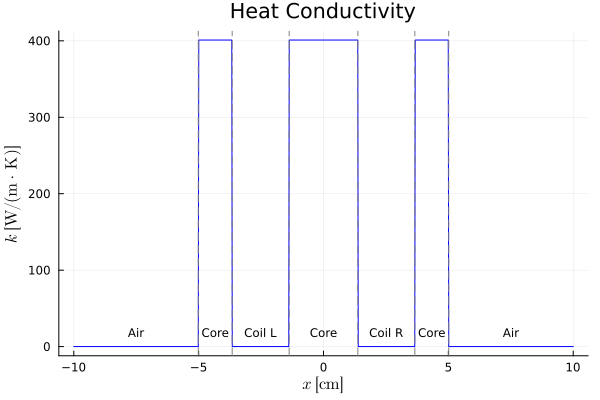

In [11]:
using Plots

# Evaluate heat conductivity at interpolation points
heat_conductivity_elements = heat_conductivity_func ∘ CellField(tags, Ω)
x_int = collect(range(-0.1, 0.1, length=1000))
coord = [VectorValue(x_) for x_ in x_int]
heat_conductivity_vals = heat_conductivity_elements(coord)

# Create the plot
p_k = plot(x_int * 1e2, heat_conductivity_vals, xlabel=L"x\ \mathrm{[cm]}", ylabel=L"k\ \mathrm{[W/(m \cdot K)]}", color=:blue, lw=1, legend=false, title="Heat Conductivity")

# Add annotations (boundaries and region labels)
vline!(p_k, boundaries * 1e2, color=:grey, linestyle=:dash, label="")
plot_ylims_k = Plots.ylims(p_k)
label_y_k = plot_ylims_k[1] + 0.05 * (plot_ylims_k[2] - plot_ylims_k[1]) # Adjust y position for labels
annotate!(p_k, [(midpoints[i]*1e2, label_y_k, text(region_labels[i], 8, :center, :bottom)) for i in eachindex(midpoints)])

display(p_k)

In [ ]:

heat_problem = solve_1d_steady_heat_weak_form(Ω, dΩ, tags, heat_conductivity_func, Q)

dirichlet_temp_value = 293 # K
field_type_temp = Float64 # Use Float64 for temperature field

U_temp, V_temp = setup_fe_spaces(model, order, field_type_temp, dirichlet_tag, dirichlet_temp_value)

T = solve_fem_problem(heat_problem, U_temp, V_temp) # Temperature field

Setting up single-field space.


LoadError: SingularException(0)

## Visualization (Magnitudes)

In [8]:
# Define geometry boundaries for plotting
a_len = 100.3e-3; b_len = 73.15e-3; c_len = 27.5e-3
xa1 = -a_len/2; xb1 = -b_len/2; xc1 = -c_len/2
xc2 = c_len/2; xb2 = b_len/2; xa2 = a_len/2
boundaries = [xa1, xb1, xc1, xc2, xb2, xa2]

6-element Vector{Float64}:
 -0.05015
 -0.036575
 -0.01375
  0.01375
  0.036575
  0.05015

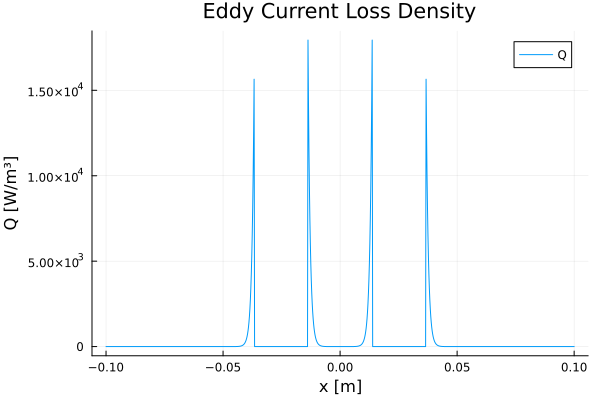

In [10]:
# Define points for visualization
x_int = collect(range(-0.1, 0.1, length=1000))
coord = [VectorValue(x_) for x_ in x_int]

# Evaluate magnitudes at interpolation points
Az_mag_vals = Az_mag(coord)
B_mag_vals = B_mag(coord)
Jeddy_mag_vals = Jeddy_mag(coord)
Q_vals = Q(coord)
# T_vals = T(coord)

# Calculate midpoints for region labels
x_min_plot = minimum(x_int); x_max_plot = maximum(x_int)
midpoints = [(x_min_plot + xa1)/2, (xa1 + xb1)/2, (xb1 + xc1)/2, (xc1 + xc2)/2, (xc2 + xb2)/2, (xb2 + xa2)/2, (xa2 + x_max_plot)/2]
region_labels = ["Air", "Core", "Coil L", "Core", "Coil R", "Core", "Air"]

p_q = plot(x_int, Q_vals, label="Q", xlabel="x [m]", ylabel="Q [W/m³]", title="Eddy Current Loss Density", legend=:topright)

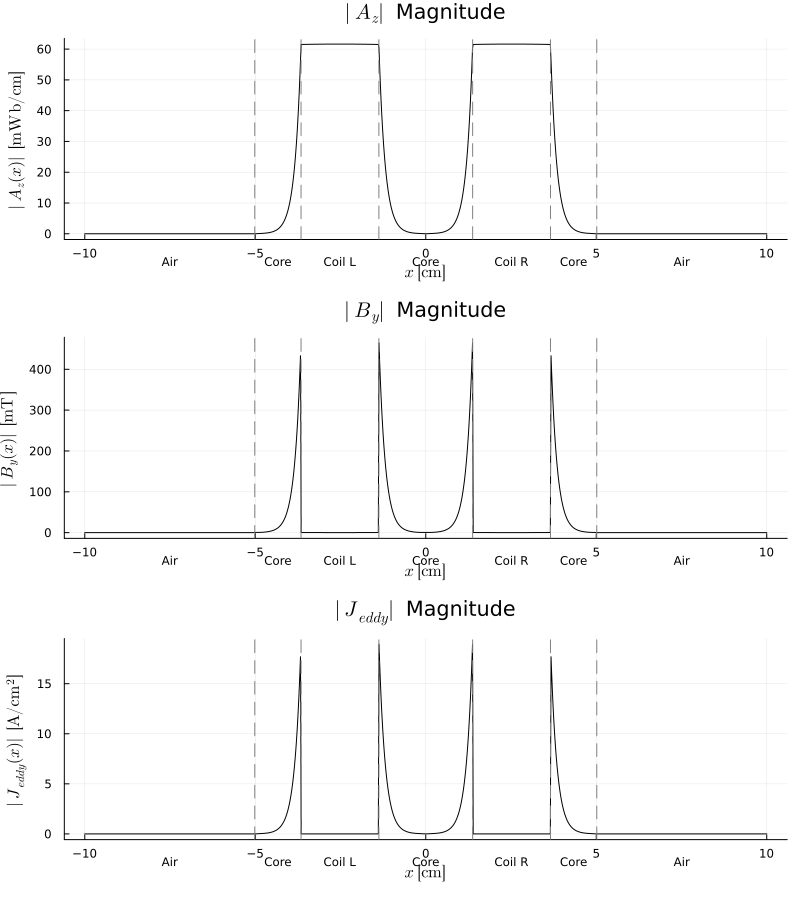

In [ ]:


# Plot Magnitudes
p1 = plot(x_int * 1e2, Az_mag_vals * 1e5, xlabel=L"x\ \mathrm{[cm]}", ylabel=L"|A_z(x)|\ \mathrm{[mWb/cm]}", color=:black, lw=1, legend=false, title=L"|A_z|" *" Magnitude")
p2 = plot(x_int * 1e2, B_mag_vals * 1e3, xlabel=L"x\ \mathrm{[cm]}", ylabel=L"|B_y(x)|\ \mathrm{[mT]}", color=:black, lw=1, legend=false, title=L"|B_y|" *" Magnitude")
p3 = plot(x_int * 1e2, Jeddy_mag_vals * 1e-4, xlabel=L"x\ \mathrm{[cm]}", ylabel=L"|J_{eddy}(x)|\ \mathrm{[A/cm^2]}", color=:black, lw=1, legend=false, title=L"|J_{eddy}|" *" Magnitude")
p4 = plot(x_int * 1e2, T(coord) * 1e3, xlabel=L"x\ \mathrm{[cm]}", ylabel=L"T\ \mathrm{[K]}", color=:black, lw=1, legend=false, title="Temperature")

# Add annotations
for p in [p1, p2, p3, p4]
    vline!(p, boundaries * 1e2, color=:grey, linestyle=:dash, label="")
    plot_ylims = Plots.ylims(p)
    label_y = plot_ylims[1] - 0.08 * (plot_ylims[2] - plot_ylims[1])
    annotate!(p, [(midpoints[i]*1e2, label_y, text(region_labels[i], 8, :center, :top)) for i in eachindex(midpoints)])
end

plt_mag = plot(p1, p2, p3, p4, layout=(3,1), size=(800, 900))
savefig(plt_mag, joinpath(paths["OUTPUT_DIR"], "magnetodynamics_harmonic_coupled_magnitudes.pdf"))
display(plt_mag)